In [1]:
import re
import pandas as pd
import numpy as np
from geopy.distance import great_circle
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import matplotlib.pyplot as plt
plt.style.use(style="ggplot")
import seaborn as sns

# Preprocess data

In [2]:
# read csv data
# listings_original.csv is original data, listings1.csv is roughly preprocessed data

df_raw_raw=pd.read_csv("listings1.csv")
df_raw_raw = df_raw_raw.set_index('id')
df_ori=pd.read_csv("listings_original.csv")
df_ori = df_ori.set_index('id')

/Users/mac/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (61,62) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df_raw=pd.concat([df_raw_raw,df_ori["extra_people"],df_ori["guests_included"]],axis=1)

In [4]:
df_raw.extra_people = df_raw.extra_people.str.replace('$', '').str.replace(',', '').astype(float)
df_raw.drop(columns=['host_verifications'], inplace=True)

In [5]:
# data information

df_raw.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 28078 entries, 6983.0 to 38969421.0
Data columns (total 41 columns):
host_since                          28052 non-null float64
host_response_rate                  13738 non-null float64
host_is_superhost                   28052 non-null float64
host_listings_count                 28052 non-null float64
host_has_profile_pic                28052 non-null float64
host_identity_verified              28052 non-null float64
zipcode                             27254 non-null float64
is_location_exact                   28076 non-null float64
property_type                       28076 non-null float64
room_type                           28076 non-null float64
accommodates                        28076 non-null float64
bathrooms                           28061 non-null float64
bedrooms                            28063 non-null float64
beds                                28055 non-null float64
bed_type                            28076 non-null fl

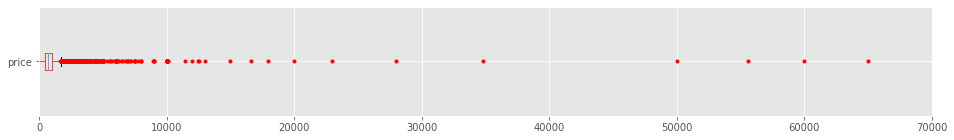

In [6]:
# plot price outliers in(0,70000)

red_square = dict(markerfacecolor='r', markeredgecolor='r', marker='.')
df_raw['price'].plot(kind='box', xlim=(0, 70000), vert=False, flierprops=red_square, figsize=(16,2))

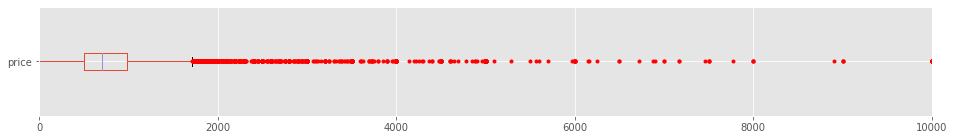

In [7]:
# plot price outliers in(0,10000)

red_square = dict(markerfacecolor='r', markeredgecolor='r', marker='.')
df_raw['price'].plot(kind='box', xlim=(0, 10000), vert=False, flierprops=red_square, figsize=(16,2))

In [8]:
# delete listings of price above 4000

df_raw.drop(df_raw[ (df_raw.price > 4000) | (df_raw.price == 0) ].index, axis=0, inplace=True)

In [9]:
# show price's mean, standard deviation, minimum, quartils, and maximum 

df_raw['price'].describe()

count    27944.000000
mean       797.042764
std        445.567157
min         68.000000
25%        499.000000
50%        703.000000
75%        976.000000
max       3999.000000
Name: price, dtype: float64

In [10]:
# detect missing values

df_raw.isna().sum()

host_since                             26
host_response_rate                  14289
host_is_superhost                      26
host_listings_count                    26
host_has_profile_pic                   26
host_identity_verified                 26
zipcode                               821
is_location_exact                       2
property_type                           2
room_type                               2
accommodates                            2
bathrooms                              16
bedrooms                               15
beds                                   22
bed_type                                2
amenities                               2
price                                   2
security_deposit                    13849
cleaning_fee                         8832
minimum_nights                          2
maximum_nights                          2
number_of_reviews                       2
number_of_reviews_ltm                   2
review_scores_rating              

In [11]:
# process missing values

df_raw.cleaning_fee.fillna(0, inplace=True)
df_raw.security_deposit.fillna(0, inplace=True)
df_raw.host_has_profile_pic.fillna(1,inplace=True)
df_raw.host_listings_count.fillna(0,inplace=True)
df_raw.host_identity_verified.fillna(0,inplace=True)

In [12]:
df_raw.drop(columns=['square_feet', 'host_response_rate'], inplace=True)
df_raw.dropna(subset=["host_since",'bathrooms', "beds","review_scores_rating",
                      "review_scores_accuracy","review_scores_cleanliness",
                      'bedrooms', "review_scores_checkin","review_scores_communication",
                      "review_scores_location","review_scores_value","reviews_per_month","zipcode"], inplace=True)

In [13]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 22553 entries, 6983.0 to 38873899.0
Data columns (total 39 columns):
host_since                          22553 non-null float64
host_is_superhost                   22553 non-null float64
host_listings_count                 22553 non-null float64
host_has_profile_pic                22553 non-null float64
host_identity_verified              22553 non-null float64
zipcode                             22553 non-null float64
is_location_exact                   22553 non-null float64
property_type                       22553 non-null float64
room_type                           22553 non-null float64
accommodates                        22553 non-null float64
bathrooms                           22553 non-null float64
bedrooms                            22553 non-null float64
beds                                22553 non-null float64
bed_type                            22553 non-null float64
amenities                           22553 non-null ob

In [14]:
# calculate distance to city center based on geographic information, latitude and longitude

def distance_to_mid(lat, lon):
    Copenhagen_centre = (55.675929, 12.569074)
    accommodation = (lat, lon)
    return great_circle(Copenhagen_centre, accommodation).km
df_raw['distance'] = df_raw.apply(lambda x: distance_to_mid(x.latitude, x.longitude), axis=1)

In [15]:
# extract existing "size" from "description" feature

df_raw['size'] = df_raw['description'].str.extract('(\d{2,3}\s?[smSM])', expand=True)
df_raw['size'] = df_raw['size'].str.replace("\D", "")
df_raw['size'] = df_raw['size'].astype(float)

print('NaNs in size_column absolute:     ', df_raw['size'].isna().sum())
print('NaNs in size_column in percentage:', round(df_raw['size'].isna().sum()/len(df_raw),3), '%')

NaNs in size_column absolute:      8823
NaNs in size_column in percentage: 0.391 %


In [16]:
df_raw['size'].notna().sum()

13730

In [17]:
df_raw.drop(['description'], axis=1, inplace=True)

## predicting size


In [18]:
# making dataframe for predicting size

sub_df = df_raw[['accommodates', 'bathrooms', 'bedrooms',  'price', 'cleaning_fee', 
                 'security_deposit', 'extra_people', 'guests_included', 'distance', 'size']]

In [19]:
train_data = sub_df[sub_df['size'].notnull()]
test_data  = sub_df[sub_df['size'].isnull()]

X_train = train_data.drop('size', axis=1)
X_test  = test_data.drop('size', axis=1)
y_train = train_data['size']

In [20]:
# using linear regression for predicting

linreg = LinearRegression()
linreg.fit(X_train, y_train)

y_test = linreg.predict(X_test)
y_test = pd.DataFrame(y_test)
y_test.columns = ['size']

In [21]:
prelim_index = pd.DataFrame(X_test.index)
prelim_index.columns = ['prelim']

y_test = pd.concat([y_test, prelim_index], axis=1)
y_test.set_index(['prelim'], inplace=True)

In [22]:
new_test_data = pd.concat([X_test, y_test], axis=1)
sub_df_new = pd.concat([new_test_data, train_data], axis=0)
df_raw.drop(['accommodates', 'bathrooms', 'bedrooms', 'price', 'cleaning_fee', 
             'security_deposit', 'extra_people', 'guests_included', 'distance', 'size'], 
            axis=1, inplace=True)

df = pd.concat([sub_df_new, df_raw], axis=1)

In [23]:
# show size's mean, standard deviation, minimum, quartils, and maximum 

df['size'].describe()

count    22553.000000
mean        87.450263
std        110.402314
min          0.000000
25%         15.000000
50%         85.007766
75%         90.502084
max        980.000000
Name: size, dtype: float64

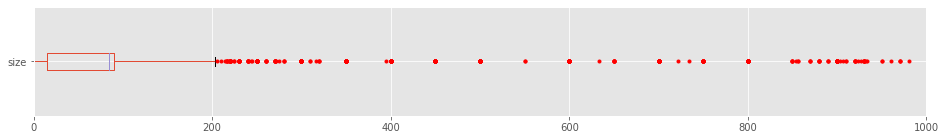

In [24]:
# plot size outliers

red_square = dict(markerfacecolor='r', markeredgecolor='r', marker='.')
df['size'].plot(kind='box', xlim=(0, 1000), vert=False, flierprops=red_square, figsize=(16,2));

In [25]:
# delete size over 300 or equal to 0

df.drop(df[ (df['size'] == 0.) | (df['size'] > 300.) ].index, axis=0, inplace=True)
print("The dataset has {} rows and {} columns - after being engineered.".format(*df.shape))

The dataset has 21706 rows and 40 columns - after being engineered.


In [26]:
# show features from "amendities"

from collections import Counter
results = Counter()
df['amenities'].str.strip('{}')\
               .str.replace('"', '')\
               .str.lstrip('\"')\
               .str.rstrip('\"')\
               .str.split(',')\
               .apply(results.update)

results.most_common(40)

[('Kitchen', 21124),
 ('Wifi', 20989),
 ('Heating', 20695),
 ('Essentials', 20683),
 ('TV', 14959),
 ('Washer', 14614),
 ('Laptop friendly workspace', 14339),
 ('Smoke detector', 14313),
 ('Iron', 14096),
 ('Hangers', 13397),
 ('Hair dryer', 13356),
 ('Shampoo', 11661),
 ('Hot water', 11396),
 ('Family/kid friendly', 9942),
 ('Dryer', 8629),
 ('Refrigerator', 7750),
 ('Dishes and silverware', 7352),
 ('Stove', 7330),
 ('Oven', 7267),
 ('Cooking basics', 7217),
 ('Buzzer/wireless intercom', 7119),
 ('Internet', 6558),
 ('Bed linens', 6482),
 ('Dishwasher', 5479),
 ('Host greets you', 5292),
 ('Paid parking off premises', 5279),
 ('Private entrance', 4732),
 ('Cable TV', 4616),
 ('Free parking on premises', 4608),
 ('Coffee maker', 4167),
 ('Microwave', 3887),
 ('Patio or balcony', 3516),
 ('First aid kit', 3508),
 ('Elevator', 3440),
 ('translation missing: en.hosting_amenity_50', 3414),
 ('Garden or backyard', 3047),
 ('Fire extinguisher', 2994),
 ('Children’s books and toys', 2769),
 

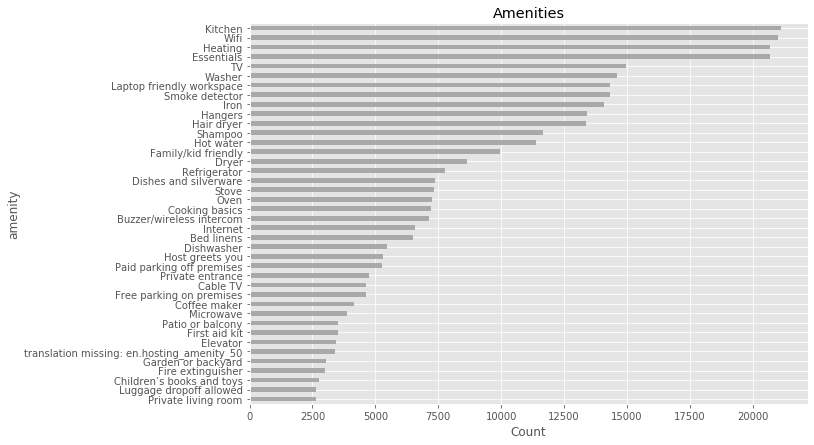

In [27]:
# plot top 40 amendities

sub_df = pd.DataFrame(results.most_common(40), columns=['amenity', 'count'])
sub_df.sort_values(by=['count'], ascending=True).plot(kind='barh', x='amenity', y='count',  
                                                      figsize=(10,7), legend=False, color='darkgrey',
                                                      title='Amenities')
plt.xlabel('Count');

In [28]:
'''
extract (TV,  Laptop_friendly_workspace, Family_kid_friendly, Host_greets_you, cooking_basics, 
Patio_or_balcony,garden_or_beckyard) as individual features
and delete "amendities" column
'''

df['TV'] = df['amenities'].str.contains('TV')
df['Laptop_friendly_workspace'] = df['amenities'].str.contains('Laptop friendly workspace')
df['Family_kid_friendly'] = df['amenities'].str.contains('Family/kid friendly')
df['Host_greets_you'] = df['amenities'].str.contains('Host greets you')
df['cooking_basics'] = df['amenities'].str.contains('Cooking basics')
df['Patio_or_balcony'] = df['amenities'].str.contains('Patio or balcony')
df['garden_or_beckyard'] = df['amenities'].str.contains('Garden or backyard')
df.drop(['amenities'], axis=1, inplace=True)

## data visualization

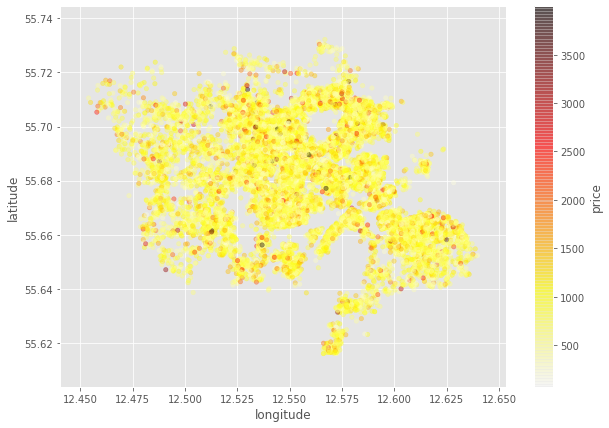

In [29]:
# plot price vs lcoation

df.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4, figsize=(10,7), 
        c="price", cmap="hot_r", colorbar=True, sharex=False);

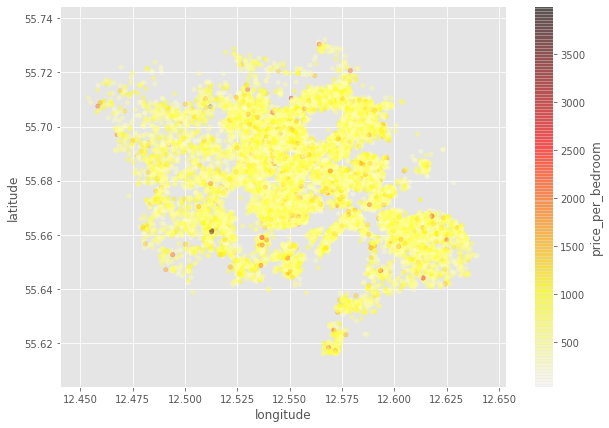

In [30]:
# plot price vs price_per_bedroom

df_copy=df.copy()
df_copy["price_per_bedroom"]=df_copy["price"]/df_copy["bedrooms"]
df_copy.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4, figsize=(10,7), 
        c="price_per_bedroom", cmap="hot_r", colorbar=True, sharex=False);

In [31]:
# extract neighbourhood information 

neighbour=pd.read_csv("neighbourhood.csv", sep=';')   
nei={}
for i in neighbour.index:
    if neighbour.at[i,"area_code2"].astype(int)<=neighbour.at[i,"area_code1"].astype(int):
        celling=neighbour.at[i,"area_code1"].astype(int)+1
    else:
        celling=neighbour.at[i,"area_code2"].astype(int)+1
#         print(neighbour.at[i,"area_code1"].astype(int))
    nei[range(neighbour.at[i,"area_code1"].astype(int),celling)]=neighbour.at[i,"Neighbourhood"]

In [32]:
def zip_to_dis(x):
    for i, j in enumerate(nei.keys()):
        if x in j:
            return nei[j]
df['neighbourhood'] = df.apply(lambda x: zip_to_dis(x.zipcode), axis=1)  
df['neighbourhood'].value_counts().sort_values()

Herlev              1
Roedovre            3
Hvidovre            4
Soeborg             9
Kastrup            13
Nordhavn           46
Hellerup           47
Broenshoej        383
Vanloese          478
Koebenhavn SV     732
Valby             933
Koebenhavn NV    1133
Frederiksberg    2386
Koebenhavn K     2465
Koebenhavn OE    2538
Koebenhavn V     2772
Koebenhavn S     3554
Koebenhavn N     4207
Name: neighbourhood, dtype: int64

In [33]:
# delete listings in Herlev,Roedovre, Hvidovre, and Soeborg 

df_n=df.copy()
df_n=df_n.drop(df_n[df_n.neighbourhood=="Herlev"].index)
df_n=df_n.drop(df_n[df_n.neighbourhood=="Roedovre"].index)
df_n=df_n.drop(df_n[df_n.neighbourhood=="Hvidovre"].index)
df_n=df_n.drop(df_n[df_n.neighbourhood=="Soeborg"].index)

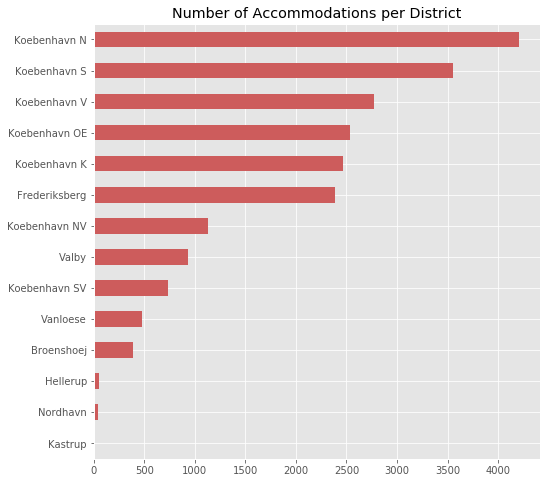

In [34]:
# plot number of Accommodations per District

plt.figure(figsize=(8,8))
df_n['neighbourhood'].value_counts().sort_values().plot(kind='barh', color='IndianRed')
plt.title('Number of Accommodations per District');

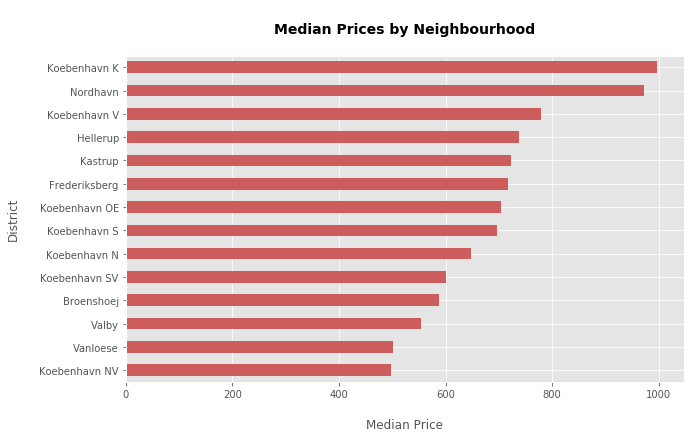

In [35]:
# plot Median Prices by Neighbourhood

df_grouped = pd.DataFrame(df_n.groupby(['neighbourhood'])['price'].agg(np.median))
df_grouped.reset_index(inplace=True)

df_grouped.sort_values(by=['price'], ascending=True)\
          .plot(kind='barh', x='neighbourhood', y='price', 
                figsize=(10,6), legend=False, color='IndianRed')
plt.xlabel('\nMedian Price', fontsize=12)
plt.ylabel('District\n', fontsize=12)
plt.title('\nMedian Prices by Neighbourhood\n', fontsize=14, fontweight='bold');

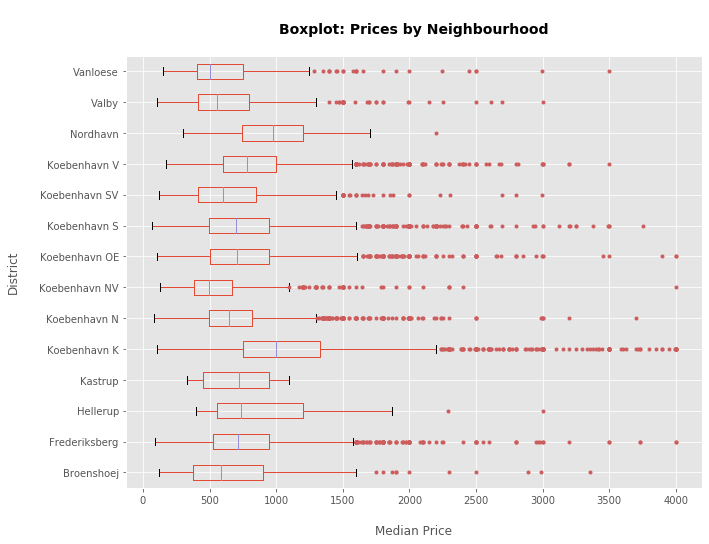

In [36]:
# plot boxplot Prices by Neighbourhood

square = dict(markerfacecolor='IndianRed', markeredgecolor='IndianRed', marker='.')

df_n.boxplot(column='price', by='neighbourhood', 
           flierprops=square, vert=False, figsize=(10,8))

plt.xlabel('\nMedian Price', fontsize=12)
plt.ylabel('District\n', fontsize=12)
plt.title('\nBoxplot: Prices by Neighbourhood\n', fontsize=14, fontweight='bold')
plt.suptitle('');

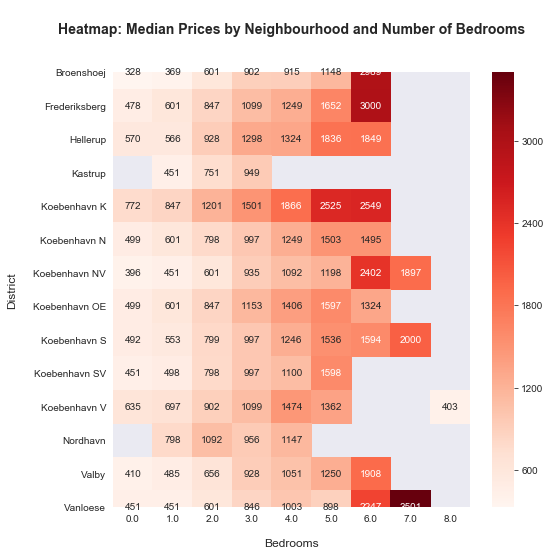

In [37]:
# heatmap for Median Prices by Neighbourhood and Number of Bedrooms

sns.set_style("dark")
plt.figure(figsize=(8,8))
sns.heatmap(df_n.groupby(['neighbourhood', 'bedrooms']).price.median().unstack(), 
            cmap='Reds', annot=True, fmt=".0f")

plt.xlabel('\nBedrooms', fontsize=12)
plt.ylabel('District\n', fontsize=12)
plt.title('\nHeatmap: Median Prices by Neighbourhood and Number of Bedrooms\n\n', fontsize=14, fontweight='bold');

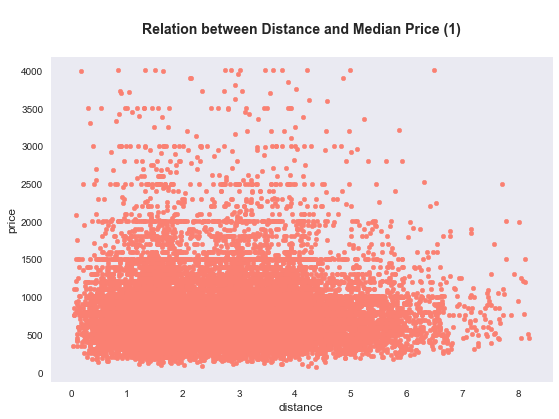

In [38]:
# two plots showing relation between Distance and Median Price

df.plot.scatter(x="distance", y="price", figsize=(9,6), c='salmon')
plt.title('\nRelation between Distance and Median Price (1)\n', fontsize=14, fontweight='bold');

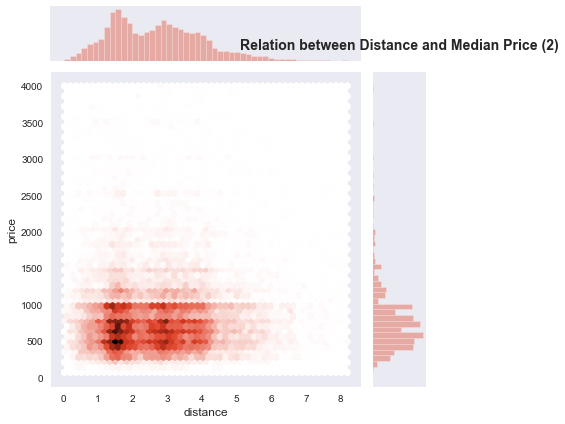

In [39]:
sns.jointplot(x=df["distance"], y=df["price"], kind='hex')
plt.title('\nRelation between Distance and Median Price (2)\n',loc='center', fontsize=14, fontweight='bold');

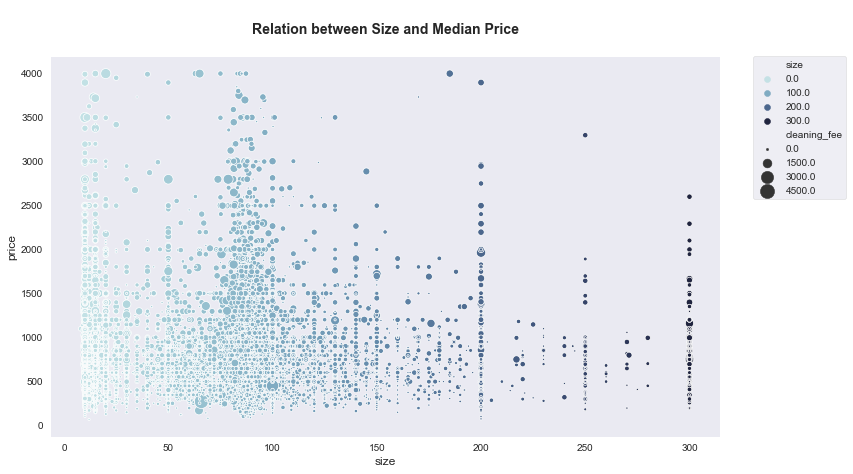

In [40]:
# dot plot showing relation between Size and Median Price

cmap = sns.cubehelix_palette(rot=-.2, as_cmap=True)
fig, ax = plt.subplots(figsize=(12,7))
ax = sns.scatterplot(x="size", y="price", size='cleaning_fee', sizes=(5, 200),
                      hue='size', palette=cmap,  data=df)

plt.title('\nRelation between Size and Median Price\n', fontsize=14, fontweight='bold')

# putting legend out of the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

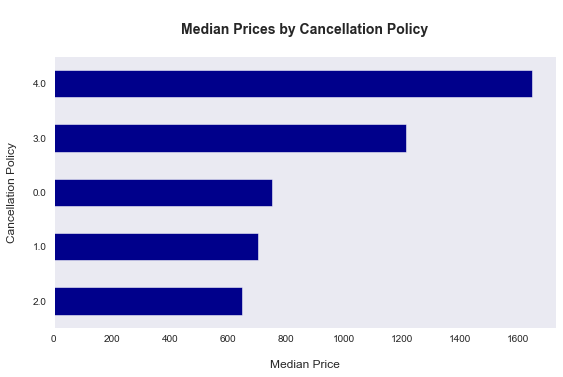

In [41]:
# plot Median Prices by Cancellation Policy

df_grouped = pd.DataFrame(df.groupby(['cancellation_policy'])['price'].agg(np.median))
df_grouped.reset_index(inplace=True)

df_grouped.sort_values(by=['price'], ascending=True)\
          .plot(kind='barh', x='cancellation_policy', y='price', 
                figsize=(9,5), legend=False, color='darkblue')

plt.xlabel('\nMedian Price', fontsize=12)
plt.ylabel('Cancellation Policy\n', fontsize=12)
plt.title('\nMedian Prices by Cancellation Policy\n', fontsize=14, fontweight='bold');

# Machine Learning

## Preprocess data (ready for classifiers)

In [117]:
# split data 8:2 into train, test 
x = df.drop(["price","neighbourhood"],axis=1)
y=df["price"]
train_X, test_X, train_y, test_y = train_test_split(x, y, test_size=0.2, random_state=0)

In [118]:
# x_train

In [119]:
'''
0-1 data normalization
MinMaxScaler subtracts the minimum value in the feature and then divides by the range. 
The range is the difference between the original maximum and original minimum

It preserves the shape of the original distribution 
without meaningfully change the information embedded in the original data.
'''

scaler = MinMaxScaler()
train_X = scaler.fit_transform(train_X)
test_X = scaler.transform(test_X)

In [82]:
# reduce data dimension using PCA

def pca(data):
    newData=data-np.mean(data,axis=0)
    covMat=np.cov(newData,rowvar=0)
    eigVals,eigVects=np.linalg.eig(np.mat(covMat))
    idx = eigVals.argsort()[::-1]   
    eigVals = eigVals[idx]
    eigVects = eigVects[:,idx]
    return newData,eigVals,eigVects

normalized_x=np.vstack((train_X,test_X))
newData,eigVals,eigVects=pca(normalized_x)

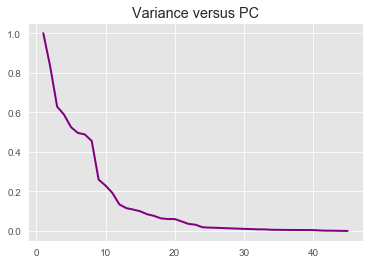

In [83]:
eigVects=np.array(eigVects)
dimension=range(1,len(eigVals)+1)
variance=eigVals/eigVals[0]

plt.style.use(style="ggplot")
plt.title("Variance versus PC")
plt.plot(dimension,variance,color="#800080",linewidth=2.0)
plt.show()

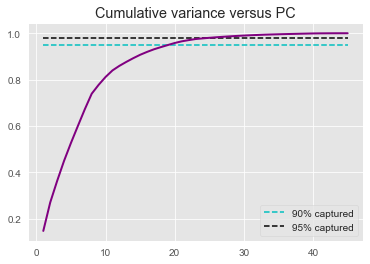

In [84]:
cumulative=[]
k=0
for i in eigVals:
    k=k+i
    cumulative.append(k)
dimension=range(1,len(cumulative)+1)
cul=cumulative/cumulative[-1]
y_p_90=0.95
y_p_95=0.98
plt.title("Cumulative variance versus PC")
plt.plot(dimension,cul,color="#800080",linewidth=2.0)
# plt.scatter(x,y,color="#800080",marker = 'o')
plt.hlines(y_p_90, 1, 45, colors = "c", linestyles = "dashed",label='90% captured')
plt.hlines(y_p_95, 1, 45, colors = "black", linestyles = "dashed",label='95% captured')
plt.legend(loc='lower right')

In [85]:
from sklearn.decomposition import PCA
pca = PCA(n_components=25)
pca_data=pca.fit_transform(normalized_x)

In [115]:
# define estimator

def estimator(pred_clf_y): 
    count=0
    for i,j in zip(list(pred_clf_y), test_y):
        if i>=j*0.7 and i<=j*1.3:
            count+=1

    RMSE = np.sqrt(mean_squared_error(test_y, pred_clf_y))
    r2 = r2_score(test_y, pred_clf_y)

    print("Confidence interval with a 30% margin of error: ", count/len(test_y))
    print("R2 score:", r2)
    print("Root Mean Square Error:", RMSE)
    print("Mean Absolute Error:",mean_absolute_error(test_y, pred_clf_y))

## XGBoost Regression

In [53]:
# predcting using xgboost

booster = xgb.XGBRegressor(objective = 'reg:squarederror', n_estimators=200, max_depth=7)

In [54]:

# create Grid
param_grid = {'learning_rate': [0.01, 0.05, 0.1], 
              'colsample_bytree': [0.6, 0.7, 1],
              'gamma': [0.0, 0.1, 0.2]}

# instantiate the tuned random forest
booster_grid_search = GridSearchCV(booster, param_grid, cv=3, n_jobs=-1)

# train the tuned random forest
booster_grid_search.fit(train_X, train_y)

# print best estimator parameters found during the grid search
print(booster_grid_search.best_params_)

/Users/mac/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


{'colsample_bytree': 0.6, 'gamma': 0.0, 'learning_rate': 0.05}


In [55]:
booster = xgb.XGBRegressor(colsample_bytree=0.7, gamma=0.0, learning_rate=0.05, 
                           max_depth=7, n_estimators=200, random_state=4, objective = 'reg:squarederror')
# train
booster.fit(train_X, train_y)

# predict
pred_train_y = booster.predict(train_X)
pred_test_y = booster.predict(test_X)

In [56]:
estimator(pred_test_y)

Confidence interval with a 30% margin of error:  0.690234914785813
R2 score: 0.5821812990483937
Root Mean Square Error: 276.4487387027235
Mean Absolute Error: 186.20466291163166


In [58]:
'''
Confidence interval with a 30% margin of error:  0.690234914785813
R2 score: 0.5821812990483937
Root Mean Square Error: 276.4487387027235
Mean Absolute Error: 186.20466291163166
'''

'\nConfidence interval with a 30% margin of error:  0.690234914785813\nR2 score: 0.5821812990483937\nRoot Mean Square Error: 276.4487387027235\nMean Absolute Error: 186.20466291163166\n'

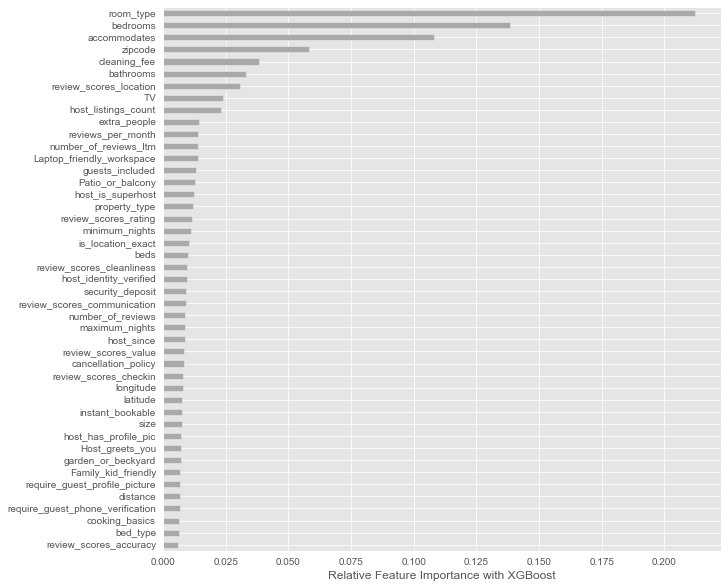

In [88]:
feat_importances = pd.Series(booster.feature_importances_, index=x.columns)
feat_importances.nlargest(45).sort_values().plot(kind='barh', color='darkgrey', figsize=(10,10))
plt.xlabel('Relative Feature Importance with XGBoost');

In [96]:
df_ori["room_type"].value_counts().sort_values()

Hotel room            64
Shared room           78
Private room        4287
Entire home/apt    23648
Name: room_type, dtype: int64

In [98]:
df_raw["room_type"].value_counts().sort_values()

2.0       38
3.0       63
1.0     3410
0.0    19042
Name: room_type, dtype: int64

[Text(0, 0, 'Shared room'),
 Text(0, 0, 'Private room'),
 Text(0, 0, 'Entire home/apt'),
 Text(0, 0, 'Hotel room')]

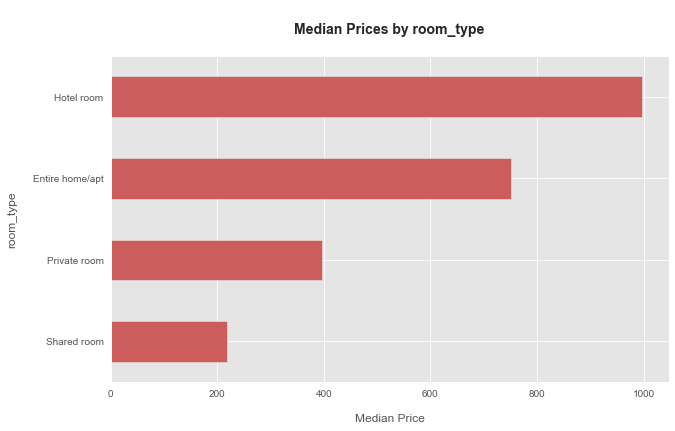

In [105]:
#plot median price by roometype

df_grouped = pd.DataFrame(df.groupby(['room_type'])['price'].agg(np.median))
df_grouped.reset_index(inplace=True)

df_grouped.sort_values(by=['price'], ascending=True)\
          .plot(kind='barh', x='room_type', y='price', 
                figsize=(10,6), legend=False, color='IndianRed')
plt.xlabel('\nMedian Price', fontsize=12)
plt.ylabel('room_type\n', fontsize=12)
plt.title('\nMedian Prices by room_type\n', fontsize=14, fontweight='bold')
ax = plt.gca()
ax.set_yticklabels(['Shared room','Private room','Entire home/apt', 'Hotel room'])

In [89]:
np.sum((pd.Series(booster.feature_importances_, index=x.columns)["review_scores_rating"],
pd.Series(booster.feature_importances_, index=x.columns)["review_scores_accuracy"],
pd.Series(booster.feature_importances_, index=x.columns)["review_scores_cleanliness"],
pd.Series(booster.feature_importances_, index=x.columns)["review_scores_checkin"],
pd.Series(booster.feature_importances_, index=x.columns)["review_scores_communication"],
pd.Series(booster.feature_importances_, index=x.columns)["review_scores_location"],
pd.Series(booster.feature_importances_, index=x.columns)["review_scores_value"]))

0.082959786

## Neural Network
### Vanilla NN

In [120]:
# predict price using vanilla neural network 

from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(hidden_layer_sizes=(5, 2),random_state=1)
clf.fit(train_X, train_y)
pred_clf_y=clf.predict(test_X)

/Users/mac/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [121]:
estimator(pred_clf_y)

Confidence interval with a 30% margin of error:  0.6573007830492861
R2 score: 0.44310348809804456
Root Mean Square Error: 319.1596090627956
Mean Absolute Error: 204.1715799170889


In [ ]:
'''
simply normalized data:
Confidence interval with a 30% margin of error:  0.6573007830492861
R2 score: 0.44310348809804456
Root Mean Square Error: 319.1596090627956
Mean Absolute Error: 204.1715799170889

after pca(25):
Confidence interval with a 30% margin of error:  0.6473975126669738
R2 score: 0.42803896338180203
Root Mean Square Error: 323.4475738450594
Mean Absolute Error: 207.6421004145555

'''


### NN in LSTM library

In [63]:
train_X.shape

(17364, 45)

In [107]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(17364, 1, 45) (17364,) (4342, 1, 45) (4342,)


In [108]:
# design network
model = Sequential()
model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

Train on 17364 samples, validate on 4342 samples
Epoch 1/400
 - 3s - loss: 190.6790 - val_loss: 195.0472
Epoch 2/400
 - 2s - loss: 190.5817 - val_loss: 195.0396
Epoch 3/400
 - 2s - loss: 190.4725 - val_loss: 194.9622
Epoch 4/400
 - 2s - loss: 190.3818 - val_loss: 194.9403
Epoch 5/400
 - 2s - loss: 190.2676 - val_loss: 194.9742
Epoch 6/400
 - 2s - loss: 190.1710 - val_loss: 194.9318
Epoch 7/400
 - 2s - loss: 190.0831 - val_loss: 194.8950
Epoch 8/400
 - 2s - loss: 189.9818 - val_loss: 194.8963
Epoch 9/400
 - 2s - loss: 189.8801 - val_loss: 194.9140
Epoch 10/400
 - 2s - loss: 189.7795 - val_loss: 194.8866
Epoch 11/400
 - 2s - loss: 189.6867 - val_loss: 194.8865
Epoch 12/400
 - 2s - loss: 189.5845 - val_loss: 194.8477
Epoch 13/400
 - 2s - loss: 189.4706 - val_loss: 194.8493
Epoch 14/400
 - 2s - loss: 189.3757 - val_loss: 194.8572
Epoch 15/400
 - 2s - loss: 189.2655 - val_loss: 194.8652
Epoch 16/400
 - 2s - loss: 189.1961 - val_loss: 194.8390
Epoch 17/400
 - 2s - loss: 189.0795 - val_loss: 

Epoch 144/400
 - 2s - loss: 178.8133 - val_loss: 193.6465
Epoch 145/400
 - 2s - loss: 178.7465 - val_loss: 193.6128
Epoch 146/400
 - 3s - loss: 178.6908 - val_loss: 193.6905
Epoch 147/400
 - 3s - loss: 178.6217 - val_loss: 193.6562
Epoch 148/400
 - 2s - loss: 178.5496 - val_loss: 193.6042
Epoch 149/400
 - 2s - loss: 178.4824 - val_loss: 193.6338
Epoch 150/400
 - 2s - loss: 178.4153 - val_loss: 193.6019
Epoch 151/400
 - 2s - loss: 178.3502 - val_loss: 193.5702
Epoch 152/400
 - 2s - loss: 178.2781 - val_loss: 193.5207
Epoch 153/400
 - 2s - loss: 178.2039 - val_loss: 193.5938
Epoch 154/400
 - 3s - loss: 178.1725 - val_loss: 193.5331
Epoch 155/400
 - 2s - loss: 178.0610 - val_loss: 193.6207
Epoch 156/400
 - 2s - loss: 178.0116 - val_loss: 193.5764
Epoch 157/400
 - 2s - loss: 177.9420 - val_loss: 193.5443
Epoch 158/400
 - 2s - loss: 177.8898 - val_loss: 193.5306
Epoch 159/400
 - 2s - loss: 177.7985 - val_loss: 193.5379
Epoch 160/400
 - 2s - loss: 177.7521 - val_loss: 193.4975
Epoch 161/400


Epoch 286/400
 - 2s - loss: 170.0490 - val_loss: 193.5484
Epoch 287/400
 - 2s - loss: 170.0038 - val_loss: 193.6008
Epoch 288/400
 - 2s - loss: 169.9411 - val_loss: 193.4932
Epoch 289/400
 - 2s - loss: 169.8675 - val_loss: 193.4829
Epoch 290/400
 - 2s - loss: 169.8408 - val_loss: 193.5823
Epoch 291/400
 - 2s - loss: 169.7861 - val_loss: 193.5858
Epoch 292/400
 - 2s - loss: 169.7189 - val_loss: 193.5193
Epoch 293/400
 - 2s - loss: 169.6818 - val_loss: 193.4699
Epoch 294/400
 - 2s - loss: 169.6050 - val_loss: 193.5379
Epoch 295/400
 - 2s - loss: 169.5626 - val_loss: 193.5479
Epoch 296/400
 - 2s - loss: 169.5391 - val_loss: 193.5618
Epoch 297/400
 - 2s - loss: 169.4537 - val_loss: 193.5248
Epoch 298/400
 - 2s - loss: 169.4305 - val_loss: 193.5765
Epoch 299/400
 - 2s - loss: 169.3758 - val_loss: 193.6017
Epoch 300/400
 - 2s - loss: 169.3055 - val_loss: 193.6038
Epoch 301/400
 - 2s - loss: 169.2367 - val_loss: 193.5110
Epoch 302/400
 - 2s - loss: 169.2069 - val_loss: 193.6254
Epoch 303/400


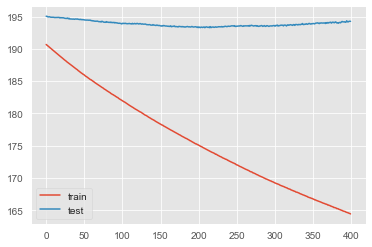

In [110]:
# fit network
history = model.fit(train_X, train_y, epochs=400, batch_size=16, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()


In [ ]:
'''
LSTM(50), epochs=200, batch_size=32: loss: 194.6626 - val_loss: 196.4582
LSTM(100), epochs=200, batch_size=32, loss: 188.9516 - val_loss: 194.9049
LSTM(100), epochs=200, batch_size=50, loss: 178.5542 - val_loss: 193.6281
LSTM(100), epochs=400, batch_size=16, loss: 170.2432 - val_loss: 193.5386

'''

In [111]:
# make a prediction
pred_lstm_y = model.predict(test_X)

In [112]:
# yhat[:100]

In [113]:
count=0
for i,j in zip(list(pred_lstm_y), test_y):
    if i>=j*0.7 and i<=j*1.3:
        count+=1
        
RMSE = np.sqrt(mean_squared_error(test_y, pred_lstm_y))
r2 = r2_score(test_y, pred_lstm_y)

print("Confidence interval with a 30% margin of error: ", count/len(test_y))
print("R2 score:", r2)
print("Root Mean Square Error:", RMSE)
print("Mean Absolute Error:",mean_absolute_error(test_y, pred_lstm_y))

Confidence interval with a 30% margin of error:  0.6706586826347305
R2 score: 0.5363581037405043
Root Mean Square Error: 291.21384080865323
Mean Absolute Error: 194.2603430297725


In [ ]:
'''
LSTM(100), epochs=400, batch_size=16:
Confidence interval with a 30% margin of error:  0.67918010133579
R2 score: 0.5350392398329429
Root Mean Square Error: 291.6277364088547
Mean Absolute Error: 193.53861458671636


'''